# Things about top movies that you don't know!

After you read this file, you will have a thorough understanding about top movies in the past 20 years!

Enjoy the three FUN TIME parts!

# Data Analysis & Visualization

If you want to hide all code cells, please click the Toggle Code button below :)

In [1]:
from IPython.display import display_html
display_html("""<button onclick="$('.input, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

Toggle Code

In [4]:
import numpy as np
import pandas as pd
import scipy
import datetime
import seaborn as sns
import os
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread
import imageio
%matplotlib inline

import time
import csv
from nltk.corpus import PlaintextCorpusReader
from nltk import sent_tokenize,word_tokenize 
from nltk.book import *
import gensim.summarization
plt.style.use('fivethirtyeight')

from scipy.misc import imread
sns.set(color_codes=True)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Load data

Load data from cleaned_data.csv. Check the Part I notebook for more preprocessing details.

This dataset includes over 1800 entries of top movie records.

Below is an example.

In [5]:
df = pd.read_csv('cleaned_data.csv', index_col='Unnamed: 0')

In [6]:
# set year, month, quarter columns
df['year'] = df['time'].apply(lambda x: x[:4])
df['month'] = df['time'].apply(lambda x:x[5:7])
df['quarter'] = df['month'].apply(lambda x: (int(x)-1)//3+1)

In [7]:
# set year, month, quarter columns
df['year'] = df['time'].apply(lambda x: x[:4])
df['month'] = df['time'].apply(lambda x:x[5:7])
df['quarter'] = df['month'].apply(lambda x: (int(x)-1)//3+1)

In [8]:
df.head()

,name,meter_score,audience_score,rating,genre,cast,director,time,studio,runtime,box_office,movie_synopsis,actor_score,director_score,year,month,quarter
0,Toy Story 3,98,89,G,"'Animation', 'Comedy', 'Kids & Family', 'Scien...","'Tom Hanks', 'Tim Allen', 'Joan Cusack', 'Ned ...",'Lee Unkrich',2010-06-18,'Walt Disney Pictures',103,414984497.0,"""Toy Story 3"" welcomes Woody, Buzz and the who...",233,138,2010,06,2
1,True Grit,96,85,PG-13,"'Action & Adventure', 'Drama', 'Western'","'Hailee Steinfeld', 'Jeff Bridges', 'Matt Damo...","'Joel Coen', 'Ethan Coen'",2010-12-22,'Paramount Pictures',110,171031347.0,Fourteen-year-old Mattie Ross (Hailee Steinfel...,273,0,2010,12,4
2,How to Train Your Dragon,98,91,PG,"'Animation', 'Kids & Family', 'Science Fiction...","'Jay Baruchel', 'Gerard Butler', 'Craig Fergus...","'Dean DeBlois', ' Chris Sanders'",2010-03-26,"'Paramount', 'DWA'",98,216900000.0,The son of a Viking chief must capture a drago...,191,0,2010,03,1
3,The King's Speech,95,92,PG-13,'Drama',"'Colin Firth', 'Helena Bonham Carter', 'Geoffr...",'Tom Hooper',2010-11-26,'The Weinstein Company',118,138300000.0,After the death of his father King George V (M...,281,403,2010,11,4
4,Inside Job,98,91,PG-13,"'Documentary', 'Special Interest'","'Matt Damon', 'William Ackman', 'Daniel Alpert...",'Charles Ferguson (III)',2010-10-08,'Sony Pictures Classics',108,4311834.0,"From Academy Award (R) nominated filmmaker, Ch...",95,0,2010,10,4


## Basic Analysis

### Great films & Box office over year

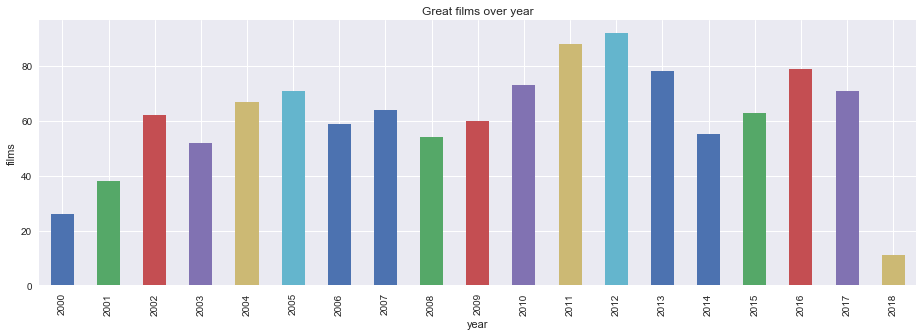

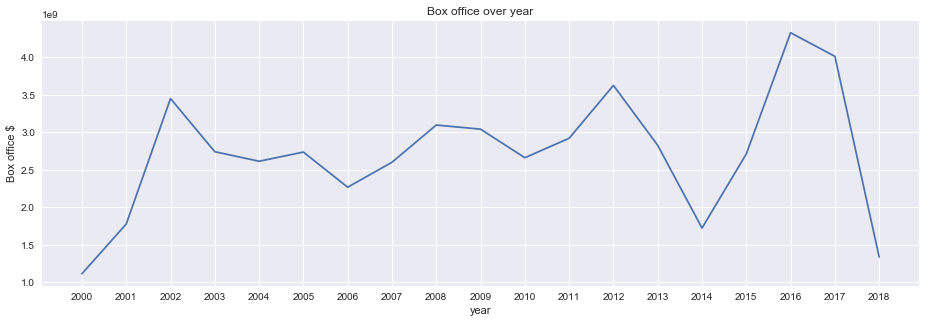

In [9]:
plt.style.use('seaborn')

plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
df.groupby(df['year']).size().plot(kind='bar')
plt.xlabel('year')
plt.ylabel('films')
plt.title('Great films over year')
plt.show()

plt.figure(figsize=(14,10))
plt.subplot(2,1,2)
plt.plot(df[['year','box_office']].groupby('year').sum())
plt.xlabel('year')
plt.ylabel('Box office $')
plt.title('Box office over year')
plt.show()

### genre trend of great movies

#### genre data processing

In [12]:
def get_columns(df_column):
    l = []
    for ele in df_column:
        if ele!='na' and ele!='nan':
            l.extend(ele.split(', '))

    return set([x[1:-1] for x in l])

genre_list = get_columns(df['genre'])
for ele in genre_list:
    df['genre_'+str(ele)]=np.where(df["genre"].str.contains(ele),1,0)

df['genre_Total'] = df['genre'].apply(lambda x: len(x.split(', ')))

#### genre wordcloud

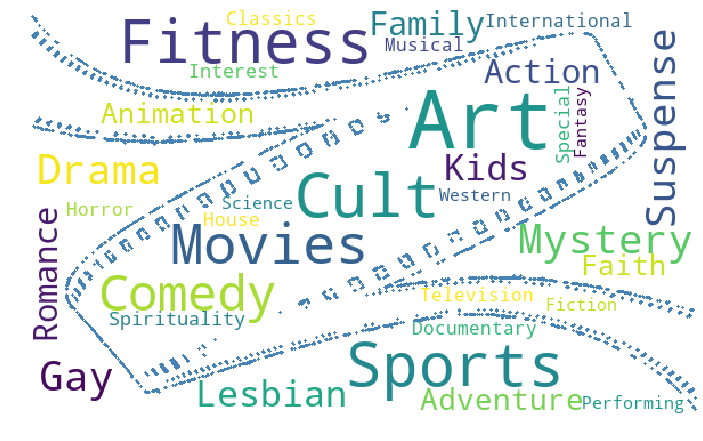

In [13]:
string = ' '.join(genre_list)
words=nltk.tokenize.word_tokenize(string)
origin_mask = imageio.imread("films.jpg")
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',mask=origin_mask, contour_width=3, 
               contour_color='steelblue').generate(' '.join(words))
plt.figure(figsize=(14,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Genre and box office distribution

In [14]:
genre_list = [str('genre_'+x) for x in genre_list]

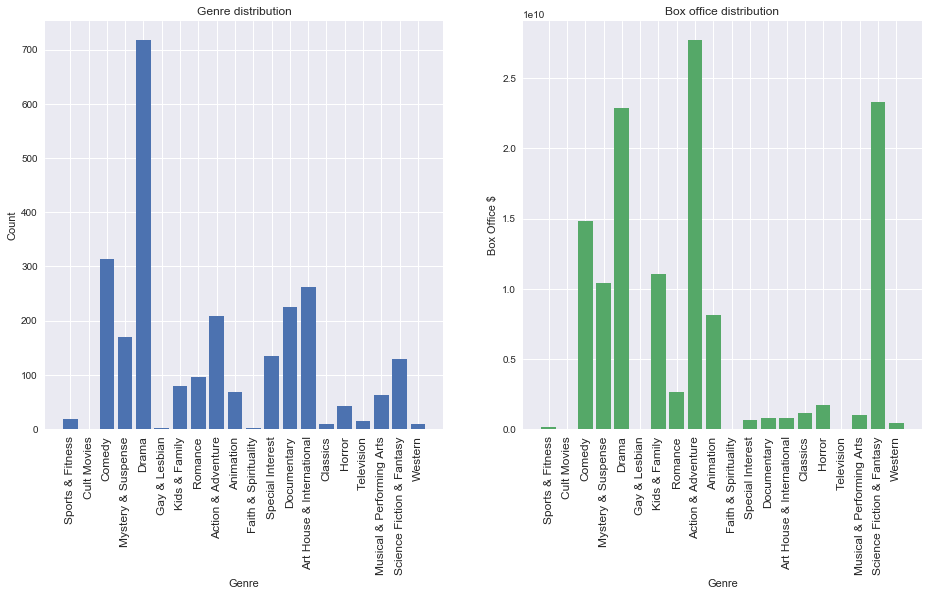

In [15]:
genre_count = {}
box_office = {}

for genre in genre_list:
    genre_count[genre[6:]] = len(df[df[genre]==1])
    box_office[genre[6:]] = sum(df[df[genre]==1]['box_office'])

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.bar(genre_count.keys(),genre_count.values())
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre distribution')
plt.xticks(rotation=90,fontsize=12)

plt.subplot(1,2,2)
plt.bar(box_office.keys(),box_office.values(),color='G')
plt.xlabel('Genre')
plt.ylabel('Box Office $')
plt.title('Box office distribution')
plt.xticks(rotation=90,fontsize=12)

plt.show()

#### genre trend over year

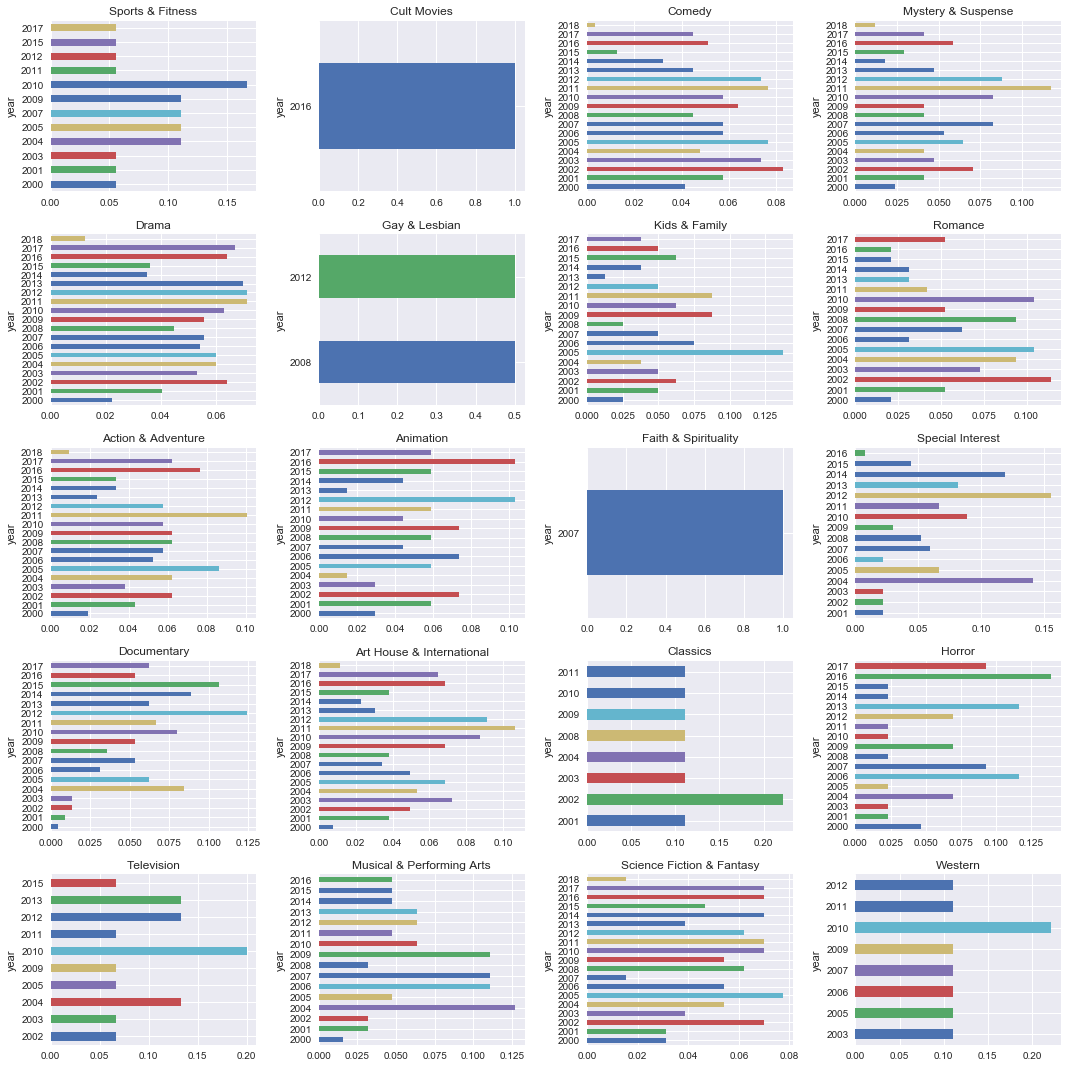

In [16]:
from matplotlib.ticker import FuncFormatter
COL_NUM = 4
ROW_NUM = 5
fig,axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(15,15))

for i, ele in enumerate(genre_list):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    ele_trend_ratio = df[df[ele]==1].groupby(df['year']).size() / len(df[df[ele]==1])
    ele_trend_ratio.plot(kind='barh',ax=ax)
    ax.set_title(ele[6:])

plt.tight_layout() 

#### genre trend over quarter

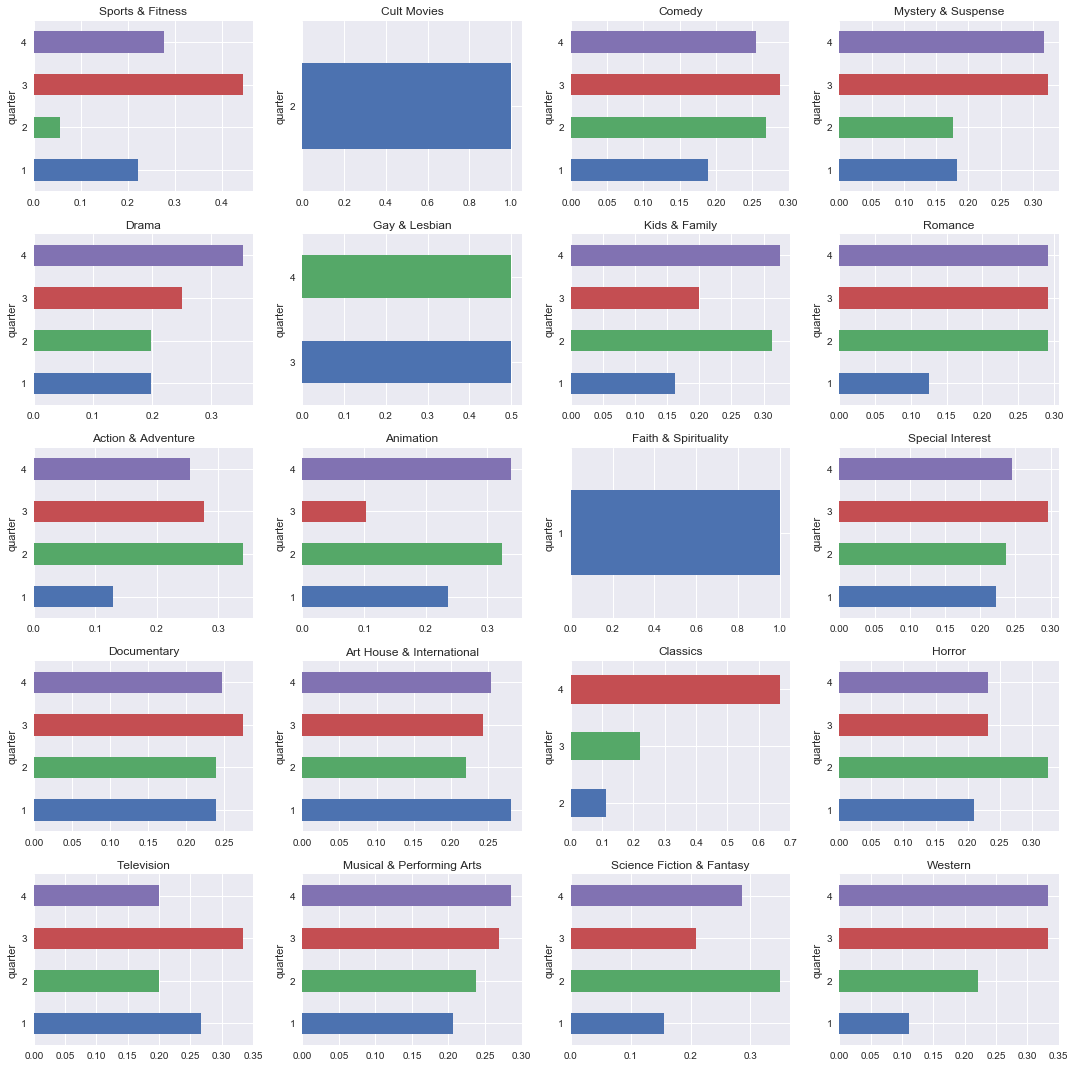

In [17]:
from matplotlib.ticker import FuncFormatter
COL_NUM = 4
ROW_NUM = 5
fig,axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(15,15))

for i, ele in enumerate(genre_list):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    ele_trend_ratio = df[df[ele]==1].groupby(df['quarter']).size() / len(df[df[ele]==1])
    ele_trend_ratio.plot(kind='barh',ax=ax)
    ax.set_title(ele[6:])

plt.tight_layout() 

### Rating distribution

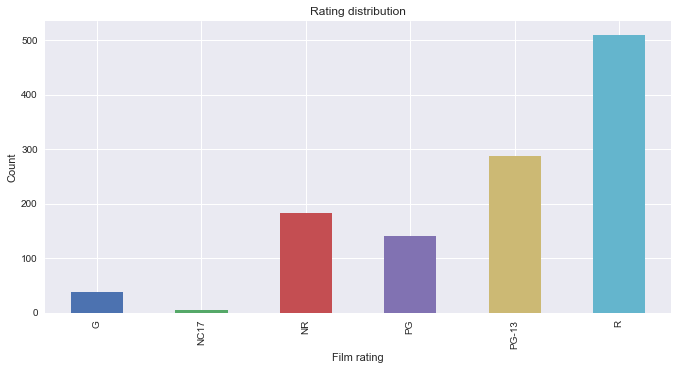

In [18]:
plt.figure(figsize=(10,5))
df.groupby(['rating']).size().plot(kind='bar')
plt.xlabel('Film rating')
plt.ylabel('Count')
plt.title('Rating distribution')
plt.show()

### Director explorations

#### Director data processing

In [19]:
dic = {}
for directors in df['director']:
    director_list = directors.split(', ')
    for director in director_list:
        dic[director] = dic.get(director,0)+1
dic = sorted(dic.items(),key=lambda x:x[1],reverse=True)

top_director = [x for x in dic if x[1]>=7]
print('Top Directors: ',top_director, '\n')
director_name = top_director[0][0][1:-1]
print('Number One Director: ',director_name)

Top Directors:  [("'Joel Coen'", 10), ("'Steven Soderbergh'", 8), ("'Christopher Nolan'", 7), ("'Jon Favreau'", 7), ("'Werner Herzog'", 7), ("'Steven Spielberg'", 7)] 

Number One Director:  Joel Coen


#### Brief look at top directors' preference on genre

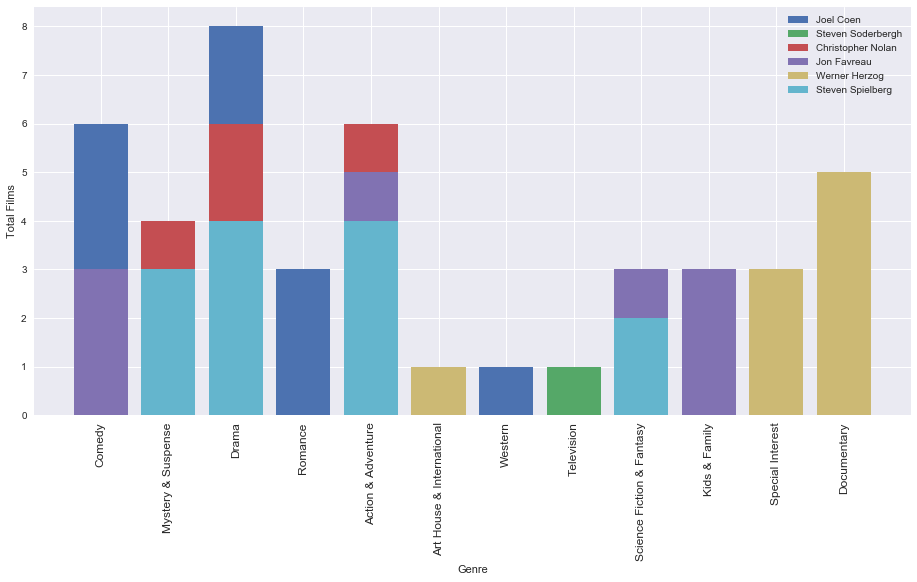

In [20]:
plt.figure(figsize=(14,7))
for director in top_director:
    sub_df = df[[director[0] in directors for directors in [ele.split(', ') for ele in df['director']]]]
    record = {}
    for genre in genre_list:
        count = sum(sub_df[genre_list][genre])
        if count>0:
            record[genre[6:]]=count
    plt.bar(record.keys(),record.values(),label=director[0][1:-1])

plt.legend(loc='upper right')
plt.xlabel('Genre')
plt.ylabel('Total Films')
plt.xticks(rotation=90,fontsize=12)
plt.show()

#### Look closer into director 'Joel Choen'

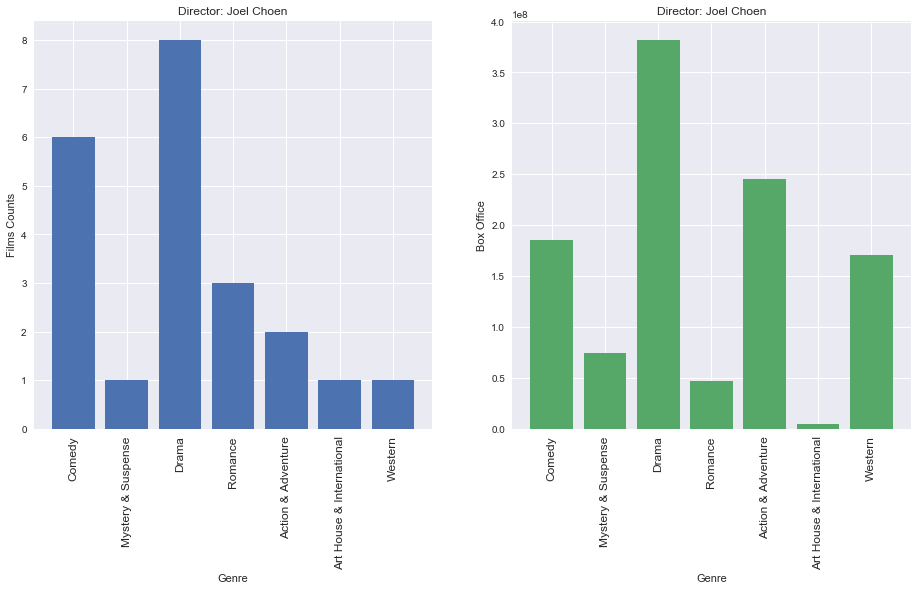

In [21]:
df_JC = df[["'Joel Coen'" in directors for directors in [ele.split(', ') for ele in df['director']]]]

record = {}
box_office = {}
for genre in genre_list:
    count = sum(df_JC[genre_list][genre])
    if count>0:
        record[genre[6:]] = count
        box_office[genre[6:]] = sum(df_JC[df_JC[genre]==1]['box_office'])

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.bar(record.keys(),record.values())
plt.xlabel('Genre')
plt.ylabel('Films Counts')
plt.title('Director: Joel Choen')
plt.xticks(rotation=90,fontsize=12)

plt.subplot(1,2,2)
plt.bar(box_office.keys(),box_office.values(),color='G')
plt.xlabel('Genre')
plt.ylabel('Box Office')
plt.title('Director: Joel Choen')
plt.xticks(rotation=90,fontsize=12)

plt.show()

# FUN TIME! Take a look at your favorite director!

In [30]:
input_name = input('Please input the director name that you are intersted in!: ')
input_name = str("'"+input_name+"'")

df_JC = df[[input_name in directors for directors in [ele.split(', ') for ele in df['director']]]]

record = {}
box_office = {}
for genre in genre_list:
    count = sum(df_JC[genre_list][genre])
    if count>0:
        record[genre[6:]] = count
        box_office[genre[6:]] = sum(df_JC[df_JC[genre]==1]['box_office'])

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.bar(record.keys(),record.values())
plt.xlabel('Genre')
plt.ylabel('Films Counts')
# plt.title('Director:', input_name)
plt.xticks(rotation=90,fontsize=12)

plt.subplot(1,2,2)
plt.bar(box_office.keys(),box_office.values(),color='G')
plt.xlabel('Genre')
plt.ylabel('Box Office')
# plt.title('Director', input_namee)
plt.xticks(rotation=90,fontsize=12)

plt.show()

Please input the director name that you are intersted in!Steven Soderbergh


# Text Mining

### read in data

In [9]:
data = pd.read_csv("all_reviews.csv",header=0)

## Preparation for text mining

### 1. Hu and Liu's sentiment analysis lexicon
http://ptrckprry.com/course/ssd/data/positive-words.txt

http://ptrckprry.com/course/ssd/data/negative-words.txt

In [10]:
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list

    #Get lists of positive and negative words
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return positive_words,negative_words

positive_words,negative_words = get_pos_neg_words()

### 2. NRC sentiment data
http://sentiment.nrc.ca/lexicons-for-research/NRC-Emotion-Lexicon.zip

In [11]:
def get_nrc_data():
    nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
    count=0
    emotion_dict=dict()
    with open(nrc,'r') as f:
        all_lines = list()
        for line in f:
            if count < 46:
                count+=1
                continue
            line = line.strip().split('\t')
            if int(line[2]) == 1:
                if emotion_dict.get(line[0]):
                    emotion_dict[line[0]].append(line[1])
                else:
                    emotion_dict[line[0]] = [line[1]]
    return emotion_dict
emotion_dict = get_nrc_data()

### 3. Vader Analysis

In [12]:
def vader_comparison(texts):
    list_vc=[]
    analyzer = SentimentIntensityAnalyzer()
    for i in range(len(rev)):
        sentences = sent_tokenize(rev[i])
        positive=compound=neutral=negative=0
        for sentence in sentences:
            vs = analyzer.polarity_scores(sentence)
            positive+=vs['pos']/(len(sentences))
            compound+=vs['compound']/(len(sentences))
            neutral+=vs['neu']/(len(sentences))
            negative+=vs['neg']/(len(sentences))
        list_vc.append((positive,compound,neutral,negative))
    return list_vc

## Sentiment Analysis

### 1. simple analysis

In [16]:
rev=data['Reviews']
def do_pos_neg_sentiment_analysis(text_rev,debug=False):
    positive_words,negative_words = get_pos_neg_words()
    from nltk import word_tokenize
    results = list()
    for text in text_rev:
        cpos = cneg = lpos = lneg = 0
        for word in word_tokenize(text):
            if word in positive_words:
                if debug:
                    print("Positive",word)
                cpos+=1
            if word in negative_words:
                if debug:
                    print("Negative",word)
                cneg+=1
        results.append((cpos/len(word_tokenize(text)),cneg/len(word_tokenize(text))))
    return results

do_pos_neg_sentiment_analysis(rev)

[(0.050936768149882905, 0.0117096018735363),
 (0.03663613655287261, 0.044962531223980015),
 (0.06025824964131994, 0.024390243902439025),
 (0.04553624925104853, 0.04313960455362492),
 (0.05665930831493746, 0.01913171449595291),
 (0.03663423010875787, 0.027475672581568404),
 (0.05685218432076601, 0.02573309395571514),
 (0.05439005439005439, 0.028749028749028748),
 (0.043429844097995544, 0.02783964365256125),
 (0.04154302670623145, 0.028684470820969338),
 (0.05235602094240838, 0.035153328347045626),
 (0.050696378830083565, 0.024512534818941504),
 (0.046788990825688076, 0.05412844036697248),
 (0.05467625899280575, 0.04460431654676259),
 (0.06598240469208211, 0.01906158357771261),
 (0.05456453305351522, 0.026232948583420776),
 (0.050087361677344205, 0.021549213744903904),
 (0.0570944036178632, 0.02035048049745619),
 (0.054, 0.017),
 (0.06240713224368499, 0.017830609212481426),
 (0.030390738060781478, 0.04775687409551375),
 (0.041945288753799395, 0.02492401215805471),
 (0.04380242311276794, 

In [11]:
pos_neg_list=do_pos_neg_sentiment_analysis(rev)
df_sub = pd.DataFrame(columns=['positive','negative'])
for i in range(len(pos_neg_list)):
    df_sub.loc[i,'positive']=pos_neg_list[i][0]
    df_sub.loc[i,'negative']=pos_neg_list[i][1]
df_sub

,positive,negative
0,0.0509368,0.0117096
1,0.0366361,0.0449625
2,0.0602582,0.0243902
3,0.0455362,0.0431396
4,0.0566593,0.0191317
5,0.0366342,0.0274757
6,0.0568522,0.0257331
7,0.0543901,0.028749
8,0.0434298,0.0278396
9,0.041543,0.0286845


In [12]:
df_pos_neg=pd.concat([data, df_sub], axis=1)
df_pos_neg

,Movie_Name,Year,Reviews,positive,negative
0,Boyhood,2014,"["" Like Michael Apted in his Seven Up! documen...",0.0509368,0.0117096
1,The Babadook,2014,[' A deftly inventive and psychologically char...,0.0366361,0.0449625
2,The LEGO Movie,2014,"[' The movie is a wonderful surprise, cleverly...",0.0602582,0.0243902
3,Nightcrawler,2014,[' Like an alternate version of Network in whi...,0.0455362,0.0431396
4,Life Itself,2014,"["" With Ebert's blessing and encouragement, Li...",0.0566593,0.0191317
5,Whiplash,2014,[' Revealing both the dangers and payoffs of a...,0.0366342,0.0274757
6,Birdman,2014,"[' Birdman, more than most, seems a film that ...",0.0568522,0.0257331
7,Mr. Turner,2014,"["" Mike Leigh's biopic is so richly detailed t...",0.0543901,0.028749
8,"Two Days, One Night",2014,"["" Consider Marion Cotillard's Oscar-nominated...",0.0434298,0.0278396
9,Gloria,2014,"["" We don't make movies in America like Gloria...",0.041543,0.0286845


### 2.NRC Analysis

In [13]:
def emotion_analyzer(text,emotion_dict=emotion_dict):
    emotions = {x for y in emotion_dict.values() for x in y}
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0
    total_words = len(text.split())
    for word in text.split():
        if emotion_dict.get(word):
            for emotion in emotion_dict.get(word):
                emotion_count[emotion] += 1/len(text.split())
    return emotion_count

In [14]:
def comparative_emotion_analyzer(text_rev):
    df_comp = pd.DataFrame(columns=['Fear','Trust','sub-Negative',
                           'sub-Positive','Joy','Disgust','Anticipation',
                           'Sadness','Surprise','Anger'],)   
    dict_list=[]
    for text in text_rev:
        result=emotion_analyzer(text)
        dict_list.append(result)
        for i in range(len(dict_list)):
            df_comp.loc[i, 'Fear'] = dict_list[i]['fear']
            df_comp.loc[i, 'Trust'] = dict_list[i]['trust']
            df_comp.loc[i, 'sub-Negative'] = dict_list[i]['negative']
            df_comp.loc[i, 'sub-Positive'] = dict_list[i]['positive']
            df_comp.loc[i, 'Joy'] = dict_list[i]['joy']
            df_comp.loc[i, 'Disgust'] = dict_list[i]['disgust']
            df_comp.loc[i, 'Anticipation'] = dict_list[i]['anticipation']
            df_comp.loc[i, 'Sadness'] = dict_list[i]['sadness']
            df_comp.loc[i, 'Surprise'] = dict_list[i]['surprise']
            df_comp.loc[i, 'Anger'] = dict_list[i]['anger']
    return df_comp
df_comparative=comparative_emotion_analyzer(rev)

In [15]:
df_comprehensive=pd.concat([df_pos_neg, df_comparative], axis=1)
df_comprehensive

,Movie_Name,Year,Reviews,positive,negative,Fear,Trust,sub-Negative,sub-Positive,Joy,Disgust,Anticipation,Sadness,Surprise,Anger
0,Boyhood,2014,"["" Like Michael Apted in his Seven Up! documen...",0.0509368,0.0117096,0.00502874,0.0186782,0.00933908,0.0438218,0.0186782,0.000718391,0.0150862,0.00359195,0.00502874,0.00215517
1,The Babadook,2014,[' A deftly inventive and psychologically char...,0.0366361,0.0449625,0.0343782,0.016178,0.0525784,0.0374115,0.016178,0.0222447,0.016178,0.0343782,0.0202224,0.0252781
2,The LEGO Movie,2014,"[' The movie is a wonderful surprise, cleverly...",0.0602582,0.0243902,0.00616197,0.022007,0.0167254,0.0501761,0.0246479,0.00352113,0.0176056,0.00352113,0.0158451,0.00792254
3,Nightcrawler,2014,[' Like an alternate version of Network in whi...,0.0455362,0.0431396,0.0146199,0.0197368,0.0255848,0.0438596,0.0153509,0.00804094,0.0175439,0.0124269,0.00804094,0.0116959
4,Life Itself,2014,"["" With Ebert's blessing and encouragement, Li...",0.0566593,0.0191317,0.0145587,0.0291174,0.021838,0.0618744,0.0254777,0.00545951,0.0245678,0.00909918,0.0100091,0.00727934
5,Whiplash,2014,[' Revealing both the dangers and payoffs of a...,0.0366342,0.0274757,0.0134371,0.0219236,0.0240453,0.0417256,0.0212164,0.00919378,0.0183876,0.0106082,0.0148515,0.0141443
6,Birdman,2014,"[' Birdman, more than most, seems a film that ...",0.0568522,0.0257331,0.0141791,0.0253731,0.0223881,0.0470149,0.0238806,0.00820896,0.0231343,0.00671642,0.0126866,0.00970149
7,Mr. Turner,2014,"["" Mike Leigh's biopic is so richly detailed t...",0.0543901,0.028749,0.00771456,0.0221794,0.0260366,0.0501446,0.0231437,0.0125362,0.0183221,0.0106075,0.0115718,0.00867888
8,"Two Days, One Night",2014,"["" Consider Marion Cotillard's Oscar-nominated...",0.0434298,0.0278396,0.0111421,0.0264624,0.0181058,0.0431755,0.0125348,0.00417827,0.0181058,0.0097493,0.00557103,0.00557103
9,Gloria,2014,"["" We don't make movies in America like Gloria...",0.041543,0.0286845,0.00752823,0.0175659,0.0188206,0.0401506,0.0150565,0.00501882,0.0138018,0.0125471,0.00878294,0.00752823


#### Calculate Net Positive and Net Negative Score


In [16]:
df_comprehensive["All_Pos"]=(df_comprehensive['Trust']+df_comprehensive['sub-Positive']+ 
                             df_comprehensive['Joy']+ df_comprehensive['Anticipation']+
                            df_comprehensive['Surprise'])
df_comprehensive["All_Neg"]=(df_comprehensive['Fear']+df_comprehensive['sub-Negative']+ 
                             df_comprehensive['Disgust']+ df_comprehensive['Sadness']+
                            df_comprehensive['Anger'])
df_comprehensive['Net']=df_comprehensive["All_Pos"]-df_comprehensive["All_Neg"]
df_comprehensive.sort_values(by="Net",ascending=False)[['Movie_Name','Net']]

,Movie_Name,Net
268,Long Way North (Tout en haut du monde),0.18125
396,All This Panic,0.174157
449,Science Fair,0.171717
36,Ernest & Célestine,0.165303
129,Iris,0.162521
221,Sing Street,0.156965
412,Crazy Rich Asians,0.151292
337,Your Name. (Kimi No Na Wa.),0.148148
14,The Tale of the Princess Kaguya,0.147482
319,"Faces Places (Visages, villages)",0.140411


##### word cloud for four movies with highest positive score

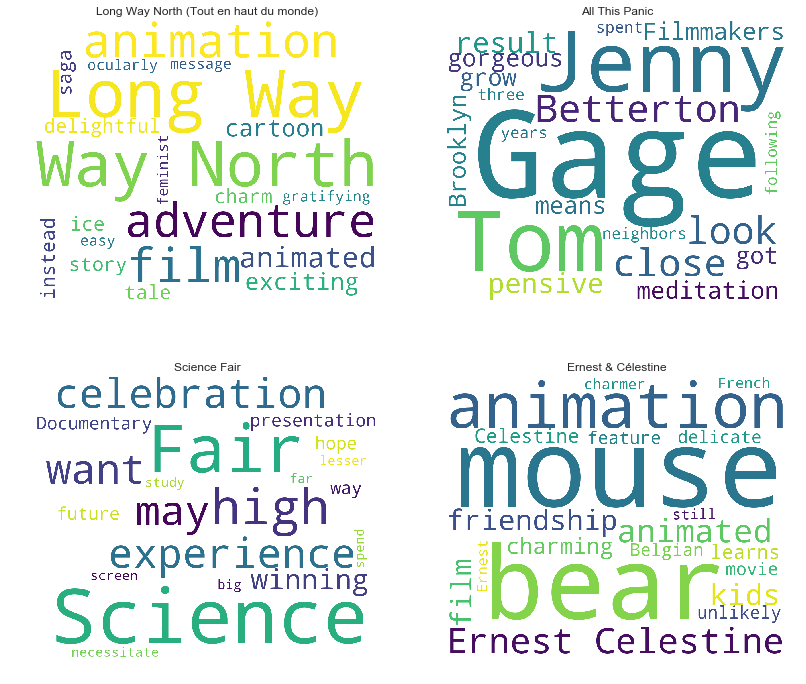

In [17]:
%matplotlib inline
DELETE_WORDS = []
def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

MIN_LENGTH = 0
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string


COL_NUM = 2
ROW_NUM = 2
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))
dic={'0':268, '1':396, '2': 449,'3': 36}
for i in dic.keys():
    text_string = remove_words(rev[dic[i]])
    text_string = remove_short_words(rev[dic[i]])
    ax = axes[int(i)//2, int(i)%2] 
    ax.set_title(df_comprehensive['Movie_Name'][dic[i]])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show()

### 3. Vader Analysis

In [18]:
list_vc_rev=vader_comparison(rev)
df_vc = pd.DataFrame(columns=['vader-comparison-positive','coumpound','neutral','vader-comparison-negative'])
for i in range(len(list_vc_rev)):
    df_vc.loc[i,'vader-comparison-positive']=list_vc_rev[i][0]
    df_vc.loc[i,'coumpound']=list_vc_rev[i][1]
    df_vc.loc[i,'neutral']=list_vc_rev[i][1]
    df_vc.loc[i,'vader-comparison-negative']=list_vc_rev[i][1]
    

In [19]:
df_overall=pd.concat([df_comprehensive, df_vc], axis=1)
df_overall['vader-net']=df_overall["vader-comparison-positive"]-df_overall["vader-comparison-negative"]
df_overall.sort_values(by="vader-net",ascending=False)[['Movie_Name','vader-net']]
#Calculate the vader-net score and sort them in descending values

,Movie_Name,vader-net
88,The Kill Team,0.411381
227,Under The Shadow,0.340624
89,Siddharth,0.337217
25,Blue Ruin,0.333346
422,Hereditary,0.312362
177,The Hunting Ground,0.301836
329,City of Ghosts,0.288677
398,Clash (Eshtebak),0.2761
20,The Missing Picture,0.262892
394,Detroit,0.262591


#### word cloud for four movies with highest vader-net score¶

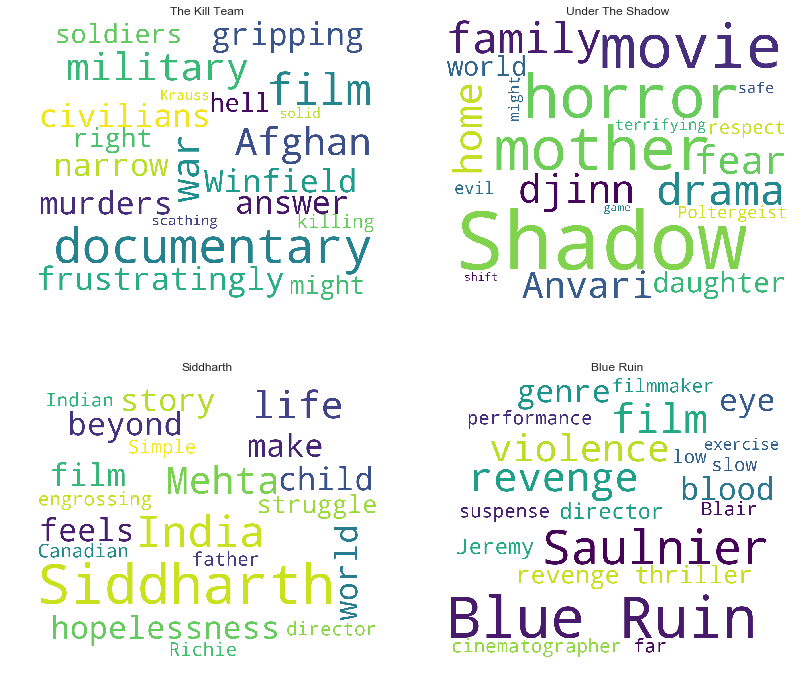

In [20]:
%matplotlib inline
DELETE_WORDS = []
def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

MIN_LENGTH = 0
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string


COL_NUM = 2
ROW_NUM = 2
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))
dic={'0':88, '1':227, '2': 89,'3': 25}
for i in dic.keys():
    text_string = remove_words(rev[dic[i]])
    text_string = remove_short_words(rev[dic[i]])
    ax = axes[int(i)//2, int(i)%2] 
    ax.set_title(df_comprehensive['Movie_Name'][dic[i]])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show()

It could be seen that the result of NRC-emotion lexicon wordlevel sentiment analysis is quite different from the result of vader sentiment analysis. In our optinion, the NRC-emotion model is relatively more accurate than the vader model. This is due to the fact that we only use the positive and negative scores in the vader model to caluculate the net and ignore the neutral scores and compound socores.
As a result, the sorting dataframe we get by doing NRC-emotion analysis could reflect a more resonable ranking of the movies with good reviews.

### General Word Cloud for all reviews

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


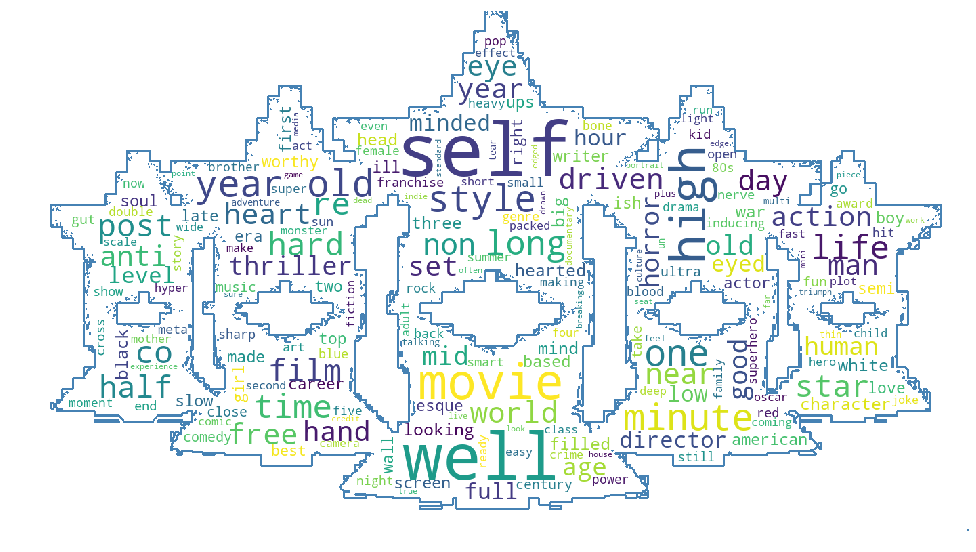

In [76]:
review=data['Reviews'].str.lower().str.cat(sep=' ')
words=nltk.tokenize.word_tokenize(review)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
origin_image = imread("Reviews.jpg")
origin_mask = origin_image
words_without_stop = nltk.FreqDist(w for w in words if w not in stopwords) 
wc = WordCloud(stopwords=STOPWORDS,background_color='white',mask=origin_mask, contour_width=3, 
               contour_color='steelblue').generate(" ".join(words_without_stop))
plt.imshow(wc)
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.axis('off')
plt.show()

## Text Summarization

In [21]:
summary_collection = []
for i in range(0,len(data['Reviews'])):
    text = data['Reviews'][i]
    temp_str = "%r"%text
    #print(temp_str)
    striptext = temp_str.replace('",','')
    striptext = striptext.replace("','",' ')
    striptext = striptext.replace('...','')
    striptext = striptext.replace('[','')
    striptext = striptext.replace(']','')
    striptext = striptext.replace("\\",'')
    striptext = striptext.replace("\'",'')
    striptext = striptext.replace("\',",'')
    striptext = striptext.replace(', "',' ')
    striptext = striptext.replace(".,",'.')
    striptext = striptext.replace("\\\\", '')
    summary = gensim.summarization.summarize(striptext, word_count=100) 
    summary_collection.append(summary)
summary_collection = pd.Series(summary_collection)


In [22]:
new_data = pd.concat([data,summary_collection],axis=1)
new_data.columns = ['Movie_Name','Year','Reviews','Summary']

### Get the summary of your favorite movie's reviews!

In [23]:
name = input('Please type in a movie name between year of 2014 to 2018: ')
print('\n')
try: 
    summ = new_data.loc[new_data['Movie_Name'] == name]['Summary']
    print("Summary:")
    print(list(summ.values)[0])

except:
    print("Uh-oh, seems like the movie is not in our database. Please check your spelling or change a movie name.")

Please type in a movie name between year of 2014 to 2018: Boyhood


Summary:
Richard Linklaters latest feels more like living a life than watching a movie.
The film ends and the credits come up and you ask the same question that you ask at the end of an evening spent with old, dear friends: where did the time go?,  A marvelous, minimal epic of a movie ,  There isnt anything else quite like "Boyhood" in the history of cinema, although that wouldnt matter one-fifth as much if it werent a moving and memorable viewing experience in the end.
Richard Linklaters coming-of-age tale is the best movie of the year, a four-star game-changer that earns its place in the cultural time capsule.


# FUN TIME! Get your favorite movie's reviews!

Let's get your favorite movie's reviews! 

Please type in a movie name between year of 2014 to 2018 below:

In [ ]:
name = input('Please type in a movie name between year of 2014 to 2018: ')

In [ ]:
try: 
    summ = new_data.loc[new_data['Movie_Name'] == name]['Summary']
    print("Summary:")
    print(list(summ.values)[0])

except:
    print("Uh-oh, seems like the movie is not in our database. Please check your spelling or change a movie name.")

# Machine Learning & Word Embedding for Box Office Prediction.ipynb

## generate dummy variables & collect features

### Import Packages and load data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("cleaned_data.csv",index_col='Unnamed: 0')

the distribution of box_office and log(box_office). We will choose log(box_office) for prediction.

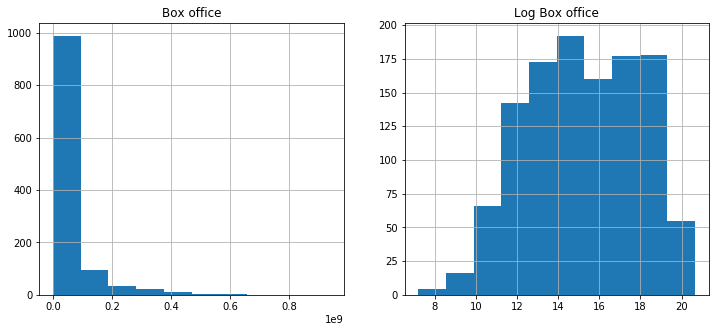

In [3]:
# using log(box office) for prediction
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df['box_office'].hist()
plt.title('Box office')

plt.subplot(1,2,2)
np.log(df['box_office']).hist()
plt.title('Log Box office')

plt.show()

### generate dummy variables

In [4]:
# generate dummy variables for rating column
raw_data = pd.concat([df,pd.get_dummies(df['rating'],prefix = 'rating')],axis=1)

In [5]:
# generate dummy variables for studio column
def get_columns(df_column):
    l = []
    for ele in df_column:
        if ele!='na' and ele!='nan':
            l.extend(ele.split(', '))

    return set([x[1:-1] for x in l])

studio_list = get_columns(raw_data['studio'])
for ele in studio_list:
    raw_data['studio_'+str(ele).strip()]=np.where(raw_data["studio"].str.contains(ele),1,0)

In [6]:
# generate dummy variables for genre column
genre_list = get_columns(df['genre'])
for ele in genre_list:
    raw_data['genre_'+str(ele)]=np.where(df["genre"].str.contains(ele),1,0)

### Caculate days from the earliest movies

Intuition: Later movies are expected to have larger box office

In [7]:
# generate 'days_to_000401' column
earliest_date = datetime.strptime(raw_data['time'].min(),"%Y-%m-%d")
print('Earliest date in data:', earliest_date)

temp_list = []
for i in range(len(raw_data)):
    temp_list.append((datetime.strptime(raw_data.iloc[i]['time'],"%Y-%m-%d")-earliest_date).days)
raw_data['days_to_000401'] = temp_list

Earliest date in data: 2000-04-01 00:00:00


### Drop columns

In [8]:
cleaned_date = raw_data.drop(['meter_score','audience_score','name','rating','genre','cast', 'director', 'time','studio'],axis=1)

### Train, validation and test split

In [9]:
from sklearn.model_selection import train_test_split

Y = np.log(cleaned_date['box_office'])
X = cleaned_date.drop(['box_office'],axis=1)
train_X, VT_X, train_Y, VT_Y = train_test_split(X,Y,test_size=0.2)
validation_X, test_X, validation_Y, test_Y = train_test_split(VT_X,VT_Y,test_size=0.5)
train_X.shape,validation_X.shape,test_X.shape,train_Y.shape,validation_Y.shape,test_Y.shape

((930, 374), (116, 374), (117, 374), (930,), (116,), (117,))

## Word Embedding

In [10]:
from gensim.models import Word2Vec
from nltk import tokenize
from nltk import word_tokenize

### Embedding model

In [11]:
corpus = []
for ele in train_X['movie_synopsis']:
    s = ele.lower()
    corpus.append(word_tokenize(s)) 

In [12]:
model = Word2Vec(corpus,size=100, window=5, min_count=1, workers=4)

### Transform train/validation/test data

In [13]:
def transform(x):
    vectors = []
    for ele in x:
        words = word_tokenize(ele.lower())
        total = 0
        vector = np.array([0]*100)
        for ele1 in words:
            try:
                vector = vector+model.wv[ele1]
                total += 1
            except:
                pass
        vector = vector/total*10
        vectors.append(vector)
    return vectors

In [14]:
# transform training data
word_embedding = pd.DataFrame(transform(train_X['movie_synopsis']),index=train_X.index)
train_X_we = train_X.join(word_embedding)
train_X_we.shape

(930, 474)

A glimpse of train_X dataset:

In [15]:
train_X_we.head()

,runtime,movie_synopsis,rating_G,rating_NC17,rating_NR,rating_PG,rating_PG-13,rating_R,studio_Village Roadshow',studio_'The Weinstein Company',...,90,91,92,93,94,95,96,97,98,99
1331,94,Flipping back and forth between the 18th centu...,0,0,0,0,0,1,0,0,...,2.337236,5.248883,1.364524,3.724325,11.596282,9.646227,-6.932783,1.411255,-1.431612,-16.268013
286,117,Matthew McConaughey stars in DALLAS BUYERS CLU...,0,0,0,0,0,1,0,0,...,2.253053,5.209550,1.290010,3.645523,11.455240,9.543464,-6.859856,1.372840,-1.338830,-16.039709
1663,112,Mild-mannered scientist Bruce Banner has been ...,0,0,0,0,1,0,0,0,...,2.389326,5.463634,1.360492,3.845735,12.053989,10.014504,-7.200775,1.458218,-1.432942,-16.856186
1095,87,A family struggles to go on after a devastatin...,0,0,0,0,0,1,0,0,...,2.505030,5.899346,1.367577,4.085153,12.964632,10.759757,-7.736104,1.479191,-1.415573,-18.027786
689,127,HIDDEN FIGURES is the incredible untold story ...,0,0,0,1,0,0,0,0,...,2.073546,5.022348,1.144095,3.412106,10.967946,9.179683,-6.553510,1.146452,-1.091280,-15.224534


In [16]:
# transform validation data
word_embedding = pd.DataFrame(transform(validation_X['movie_synopsis']),index=validation_X.index)
validation_X_we = validation_X.join(word_embedding)

# transform test data
word_embedding = pd.DataFrame(transform(test_X['movie_synopsis']),index=test_X.index)
test_X_we = test_X.join(word_embedding)

### Drop 'movie_synopsis' and rename

In [17]:
train_X = train_X_we.drop('movie_synopsis',axis=1)
validation_X = validation_X_we.drop('movie_synopsis',axis=1)
test_X = test_X_we.drop('movie_synopsis',axis=1)
train_X.shape,validation_X.shape,test_X.shape
del model

## Benchmark model: Linear Regression

The result of the Linear Regression: 

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [32]:
OLS_model = LinearRegression()
OLS_model.fit(train_X,train_Y)
print('MSE on training set:', mean_squared_error(OLS_model.predict(train_X),train_Y))
print('MSE on validation set:',mean_squared_error(OLS_model.predict(validation_X),validation_Y))

MSE on training set: 1.0836231700981958
MSE on validation set: 3.702405009145883


## Random Forest and XGBoost

### Feature Selection: Lasso

In [20]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [21]:
Lasso_model = Lasso(alpha=0.0002,max_iter=1000000)
Lasso_model.fit(train_X,train_Y)
# train_X.columns[(Lasso_model.coef_==0)][-100:]

Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Feature numbers that Lasso drop:

In [22]:
(Lasso_model.coef_==0).sum()

140

Rest feature numbers after Lasso:

In [23]:
drop_list = train_X.columns[(Lasso_model.coef_==0)]
train_X = train_X.drop(drop_list,axis=1)
validation_X = validation_X.drop(drop_list,axis=1)
test_X = test_X.drop(drop_list,axis=1)
train_X.shape[1]

333

### Random Forest

the result of Random Forest:

In [24]:
selection_model = GridSearchCV(RandomForestRegressor(),
                             {'n_estimators':[80,160,320],'max_features':[15,30,60,120,200],'max_depth':[3,5,8,16,None]},
                             cv=5)
%time selection_model.fit(train_X,train_Y)
selection_model.best_estimator_

CPU times: user 4min 20s, sys: 3.16 s, total: 4min 23s
Wall time: 4min 36s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features=120, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=320, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
best_rf_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features=120, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=320, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
best_rf_model.fit(train_X,train_Y)

print('MSE on training set:', mean_squared_error(best_rf_model.predict(train_X),train_Y))
print('MSE on validation set:',mean_squared_error(best_rf_model.predict(validation_X),validation_Y))

MSE on training set: 0.4163763531748863
MSE on validation set: 3.6782307866461825


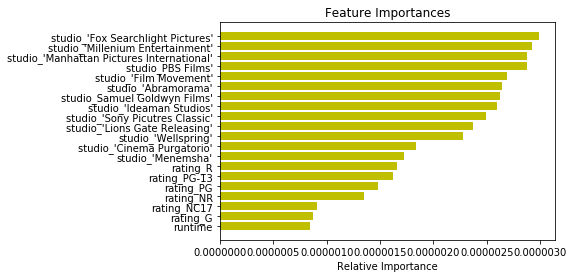

In [27]:
feature_names = [i for i in train_X.columns]
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(20), importances[indices][0:20], color='y', align='center')
plt.yticks(range(20),feature_names[0:20])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

In [28]:
from xgboost import XGBRegressor

the result of XGBoost:

In [29]:
XGB_selection_model = GridSearchCV(XGBRegressor(),
                                 {'min_child_weight':[0.25,0.5,1,2,4],'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1],
                                  'max_depth':[3,5,7,9]},
                                 cv=5)
%time XGB_selection_model.fit(train_X,train_Y)
XGB_selection_model.best_estimator_

CPU times: user 7min 46s, sys: 6.25 s, total: 7min 52s
Wall time: 8min 15s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [30]:
best_XGB = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
best_XGB.fit(train_X,train_Y)
mean_squared_error(best_XGB.predict(train_X),train_Y)

print('MSE on training set:', mean_squared_error(best_XGB.predict(train_X),train_Y))
print('MSE on validation set:',mean_squared_error(best_XGB.predict(validation_X),validation_Y))

MSE on training set: 1.6225634876564121
MSE on validation set: 3.551087928879539


## Prediction for Box office

### model selection

According to validation data
- mean square error of Linear Regression:  3.702405009145883 
- mean square error of Random Forest:  3.6782307866461825
- mean square error of XGBoost:  3.551087928879539

Therefore Random Forest will be chosen for prediction.

Below is the MSE of the chosen XGB model:

In [31]:
final_train_X = pd.concat([train_X,validation_X])
final_train_Y = pd.concat([train_Y,validation_Y])
best_XGB.fit(final_train_X,final_train_Y)
mean_squared_error(best_XGB.predict(test_X),test_Y)

2.291005589375202

### Predict Box Office

The example input for model is illstrated as follows 

- First, the raw input should be cleaned by the preprocessing ipynb file (actor_score and director_score could be calculated in that file)
- Next, the cleaned input should be processed by the ML & WE prediction ipynb file, and will be ready for the model

example input after data preprocessing:

In [33]:
# example input after data preprocessing
df.iloc[:1]

,name,meter_score,audience_score,rating,genre,cast,director,time,studio,runtime,box_office,movie_synopsis
0,Toy Story 3,98,89,G,"['Animation', 'Comedy', 'Kids & Family', 'Scie...","['Tom Hanks', 'Tim Allen', 'Joan Cusack', 'Ned...",['Lee Unkrich'],2010-06-18,['Walt Disney Pictures'],103,414984497.0,"""Toy Story 3"" welcomes Woody, Buzz and the who..."


example input for model prediction (after preprocessing):

In [34]:
# example input for model prediction
train_X[:1]

,runtime,rating_G,rating_NC17,rating_NR,rating_PG,rating_PG-13,rating_R,studio_'Menemsha',studio_'Cinema Purgatorio',studio_'Wellspring',...,41,45,53,64,66,75,79,80,81,88
1331,94,0,0,0,0,0,1,0,0,0,...,3.127892,1.489561,1.540268,-10.764084,3.885459,-4.385925,-16.398596,0.031341,-3.953347,9.97593


example prediction by XGBoost model:

In [75]:
# example prediction by XGBoost model
log_box_office = best_XGB.predict(test_X.iloc[1:2])
box_office = np.exp(log_box_office)
print('predicted box office:\t', box_office[0])
print("real box office:\t",np.exp(test_Y.iloc[1:2]).values[0])

predicted box office:	 1063724.4
real box office:	 1324335.0000000005


In [72]:
np.exp(test_Y.iloc[1:2])

1443    1324335.0
Name: box_office, dtype: float64

# Fun Time! Let's predict box offices!

* Remind: if you want to predict new entries, please run all cells from Machine Learning part (start from generate dummy variables * collecting..)

Let's pick an input index from test set and see the model performance!

Input the index number below: (0<=index<=117)

In [ ]:
index = input('please input the index number:')

In [ ]:
print('predicted box office:', best_XGB.predict(test_X.iloc[index]))
print('real box office:',test_Y.iloc[index])